# Models

### The Dataset

As a refresher:
* Data from https://data.cityofnewyork.us/browse?q=poverty
* 12 annual data files, from 2005 to 2016 inclusive (e.g. NYCgov_Poverty_MeasureData__2016.csv)
* CSV files with ~80 columns and ~60,000 rows each
* Each file had essentially the same format and contained (mostly) the same information
* Data types included:
    * Classification types encoded as integers (e.g. 1 if in poverty, 2 if not in poverty)
    * Floats for financial data (e.g. wages for the calendar year)

I'll import a cleaned version of the files (see https://github.com/c74p/Springboard/blob/master/Capstone%20Project%201%20-%20Poverty/DataWranglingSummary.ipynb) for details.

### Modeling approach

The poverty rate overall in New York City is roughly 20%, and there are lots of imbalanced groups (education, income, 
disability status, etc.).  I'll use imbalanced test-train splits to improve my model.

Overview of modeling approach:
1. Use all years, households only, classify yes/no for poverty. Test and compare Logistic Regression, Support Vector 
Machines (SVM), and Random Forest algorithms.
2. Run classifiers for individual years (the thresholds differ from year to year, so a predictor for a specific year would presumably be better for a specific year).
3. Test running regressors on houshold income and poverty threshold, in order to predict poverty classification. Test and
compare Linear Regression (Ordinary Least Squares), Stochastic Gradient Descent, and ElasticNet.
    a. This is not likely to be useful, but I'm doing it as a learning exercise.
4. Test steps 2 and 3 above at the person level, rather than at the household level.
    a. This is not likely to be useful, but I'm doing it as a learning exercise.

### Housekeeping part 1: imports and file prep

After importing we'll make some quick modifications to the data.

In [1]:
# Basic imports and setup
# See below for model-specific imports
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import time

# Model-specific imports
from dask_ml.preprocessing import Categorizer, DummyEncoder

from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import TomekLinks

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, Normalizer
from sklearn.svm import SVC

from statsmodels.discrete.discrete_model import Logit, LogitResults

%matplotlib inline

# Temporarily turn off warnings if they get to be too much
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/all_years.csv', index_col=0)

# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']
id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']
acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']
nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']
output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']
all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

In [3]:
# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'Birth', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {0: 'NA', 1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {0: 'NA', 1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
        }

# Create codes for the nyc variables that are number-coded, so we can create charts that make sense
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {0: 'NA', 1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {0: 'NA', 1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

# Create a dataframe 'cats' that uses categorical coding, rather than numerical coding, based on the dictionaries above.
#cats = df.replace(nyc_codes)
#cats = cats.replace(raw_codes)
#cats = cats.replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}, 
                     #'Off_Pov_Stat': {1:'Pov', 2:'Not Pov'}, 
                     #'AgeCateg': {1: 'U18', 2:'18-64', 3:'65+'}})

# Update one column so that NA's are all in one category
#cats.loc[cats['HIUnit_Head'].isna(), 'HIUnit_Head'] = 'NA'

In [4]:
# Key dataframes of interest

# cats is already listed above - dataframe with all of the category variables un-encoded

# All 2016 data
all_2016 = df[df.Year == 2016]
#cats_2016 = cats[cats.Year == 2016]

# 2016 data for poverty units only
# For example, the data dictionary, sheet "Column Info", cell D81, says in relation to calculating the poverty gap:
# "retain only the reference person of each family in poverty (Povunit_Rel==1 & NYCgov_Poverty == 1)"
#pu_2016 = df[(df.Year == 2016) & (df.Povunit_Rel == 1)]
#pu_cats_2016 = cats[(cats.Year == 2016) & (cats.Povunit_Rel == 'Head')]
#pu_cats_all_years = cats[(cats.Povunit_Rel == 'Head')]

# Our data set contains two sets of weights: household weights and person weights.  
# We need to separate out each column by whether it should be weighted as a household variable or a person variable.
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
personal_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'NYCgov_EITC', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork', 'PWGTP'] 
pu_vars = ['MRGP_adj', 'RNTP_adj', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'Off_Threshold', 'Off_Pov_Stat', 'NYCgov_PovGap', 'NYCgov_PovGapIndex', 'WGTP']
other_vars = ['HIUnit_Head', 'HIUnit_ID', 'NYCgov_SFN', 'Povunit_ID', 'Povunit_Rel', 'REL', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'Year']

### Feature Engineering - Adding New Poverty-Unit Variables Based on Personal Variables
Here's where we're actually adding new variables based on old variables.

From the personal-level features, we'll create new household-level features (e.g. number of kids, mean salary among 
adults, count of people making more than $30k, count of adults working between 14-26 hours/week, minimum salary among
adults working more than 26 hours/week, etc.)

This is a wall of text, not much exciting narrative here.

(Note on programming style/choices: the first function 'add_pu_columns' below is a real function, although it has a
kludge in case one of the summary calculations fails. (That happens rarely, but it's still a code smell.)

The second function, however, is not really a 'real' function; it's heavily hand-coded and relies on custom choices of
various groupings.  It was put into a function solely to comply with the DRY principle - in particular, this function
will typically be run twice (once for the whole grouping, and possibly once for a model run without the 'financial' 
features).  By putting it into a function for DRY purposes, we at least avoid accidentally running different code when we 
mean to run the same code).

In [66]:
def add_pu_columns(df, groups, group_names, categories, category_names, column):
    """
    Adds columns to dataframe 'df' containing calculations by poverty-unit, restricted by categories, considering groups.
    Calculations include any(), all(), min(), max(), count(), sum(), mean(), and % in given category.
    Input: a dataframe with multi-index consisting of 'SERIALNO', 'Povunit_ID', and 'SPORDER'; a set of masks and list of
    names for the groups; a set of masks and a list of names for the categories; and the column of interest.
    Output: no return value.  Inserts a series of columns into the dataframe including min, max, count, sum, any, all,
    % of total, and mean - within households, focusing on the groups and categories of interest. 
    """
    
    for group, group_name in zip(groups, group_names):
        for category, category_name in zip(categories, category_names):
            stacked = df[column][group & category].stack().groupby(['SERIALNO', 'Povunit_ID'])
            anys = stacked.any()
            # would love to use .all() here, but it would always be True because we filtered out everyone else
            mins = stacked.min()
            maxes = stacked.max()
            counts = stacked.count()
            sums = stacked.sum()
            means = sums/counts
            # The divisor below only restricts by 'groups' - so the final calculation is within a household, within
            # the group of interest (e.g. adults), what % is in the category of interest (e.g. works 40 hrs/week)
            divisor_for_percents = df[column][group].stack().groupby(['SERIALNO', 'Povunit_ID']).count()
            try:
                percents = counts.div(divisor_for_percents, axis=0)
                alls = percents == 1
            except: # if the calculation failed, leave percents and alls as a column of zeros
                df_len = len(df.groupby(['SERIALNO', 'Povunit_ID']).sum())
                percents = np.zeros(df_len)
                alls = np.zeros(df_len)
            
            # loop through, put in the dataframe, and fill in NAs of appropriate type
            series_and_names = zip([anys, alls, mins, maxes, counts, sums, means, percents], 
                                  ['any', 'all', 'min', 'max', 'count', 'sum', 'mean', '%'])
            for series, series_name in series_and_names:
                column_title = series_name + '_' + group_name + '_' + category_name
                df[column_title] = series
                if series_name in ['any', 'all']:
                    df[column_title] = df[column_title].fillna(False)
                else:
                    df[column_title] = df[column_title].fillna(0)
                    
def engineer_features(df, include_financials=True):
    """Create features for the dataframe. This function is heavily custom and was solely created for DRY-ness.
    Input: a poverty dataframe and whether or not to include financial features.
    Output: returns a copy of the dataframe summarized by poverty-unit, with *only* the new features included. 
    Prints progess updates to the screen as it goes.
    """

    time_0 = time.time()

    # Create dataframe to house new features 
    dfc = df.copy() # read as 'X new features'

    # Count the original # of features - later we'll just slice out the new features
    # Keep in mind that 'SERIALNO' and 'Povunit_ID' will go into the index, so we need to subtract 2 columns
    features_to_mask = len(dfc.columns) - 2
    
    # This is the largest # of people in a household; when we group the columns below, for each existing feature we'll
    # create one column for each person in a household - so we'll need to know this number at the end when we want to 
    # mask our existing features
    max_ppl = dfc.SPORDER.max()

    # First, some categoricals have odd ordering; remap them
    fix_orders = {'ENG': {0:0, 4:1, 3:2, 2:3, 1:4, 5:5}, 'WKW': {0:0, 6:1, 5:2, 4:3, 3:4, 2:5, 1:6}, 
                  'TotalWorkHrs_PU': {5:0, 4:1, 3:2, 2:3, 1:4}}
    dfc['ENG'] = dfc['ENG'].map(fix_orders['ENG'])
    dfc['WKW'] = dfc['WKW'].map(fix_orders['WKW'])
    dfc['TotalWorkHrs_PU'] = dfc['TotalWorkHrs_PU'].map(fix_orders['TotalWorkHrs_PU'])

    # Add column for total personal income
    if include_financials:
        dfc['TINP'] = dfc.WAGP_adj + dfc.INTP_adj + dfc.SEMP_adj + dfc.SSP_adj + dfc.SSIP_adj + \
                        dfc.PA_adj + dfc.RETP_adj + dfc.OI_adj

    # Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
    dfc = dfc.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

    # Create masks for age groups to use in creating new features
    mask_adult = (dfc.AgeCateg == 2) | (dfc.AgeCateg == 3)
    mask_65_plus = dfc.AgeCateg == 3
    mask_18_64 = dfc.AgeCateg == 2
    mask_kid = dfc.AgeCateg == 1
    mask_any_age = dfc.AgeCateg != 0
    mask_any = mask_any_age

    # add columns with age only, no categories
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']
    add_pu_columns(dfc, groups, group_names, [mask_any_age], ['age'], 'AGEP')

    # add columns for CIT
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_non_cit = dfc.CIT == 5
    mask_cit = (dfc.CIT != 5) & (dfc.CIT != 0)
    mask_naturalized = dfc.CIT == 4

    categories = [mask_non_cit, mask_cit, mask_naturalized, mask_any]
    category_names = ['non-cit', 'citizen', 'naturalized_cit', 'any_CIT']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'CIT')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with CIT')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for SCHL
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_college_degree = (dfc.SCHL >= 21)
    mask_HS_diploma = (dfc.SCHL >= 17)
    mask_no_diploma = (dfc.SCHL <= 16)

    categories = [mask_college_degree, mask_HS_diploma, mask_no_diploma, mask_HS_diploma & ~mask_college_degree, mask_any]
    category_names = ['college', 'HS', 'no_diploma', 'diploma_no_bachelors', 'any_SCHL']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'SCHL')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SCHL')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for SEX
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_male = dfc.SEX == 1
    mask_female = dfc.SEX == 2

    categories = [mask_male, mask_female, mask_any]
    category_names = ['male', 'female', 'any_SEX']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'SEX')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SEX')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for English ability (ENG)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # Keep in mind we switched ENG above so that 0 is NA, 1 is not at all, 2 is not very well, ..., 5 is only English
    mask_no_english = dfc.ENG == 1
    mask_eng_nvw = dfc.ENG == 2
    mask_sep_well = dfc.ENG == 3
    mask_eng_vw = dfc.ENG == 4
    mask_only_eng = dfc.ENG == 5

    categories = [mask_no_english, mask_eng_nvw, mask_sep_well, mask_eng_vw, mask_only_eng, mask_any]
    category_names = ['ENG_no', 'ENG_nvw', 'ENG_well', 'ENG_vw', 'ENG_only', 'ENG_any']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'ENG')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with ENG')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for marital status (MSP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_married = (dfc.MSP == 1) | (dfc.MSP == 2)
    mask_widowed = dfc.MSP == 3
    mask_sep_div = (dfc.MSP == 4) | (dfc.MSP == 5)
    mask_not_married = dfc.MSP == 6

    categories = [mask_married, mask_widowed, mask_sep_div, mask_not_married, mask_any]
    category_names = ['married', 'widowed', 'sep/divorced', 'not_married', 'any_MSP']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'MSP')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with MSP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for weeks worked (WKW) -- this is *weeks* worked last year, not *hours per week* (that's WKHP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # Keep in mind we switched WKW above so that 0 is none, 1 is <14 weeks, 2 is 14-26 weeks, etc.
    mask_0_WKW = dfc.WKW == 0
    mask_u14_WKW = dfc.WKW == 1
    mask_14_26_WKW = dfc.WKW == 2
    mask_27_39_WKW = dfc.WKW == 3
    mask_40_47_WKW = dfc.WKW == 4
    mask_48_49_WKW = dfc.WKW == 5
    mask_50_52_WKW = dfc.WKW == 6

    categories = [mask_0_WKW, mask_u14_WKW, mask_14_26_WKW, mask_27_39_WKW, mask_40_47_WKW, mask_48_49_WKW, mask_50_52_WKW, 
                 (mask_40_47_WKW | mask_48_49_WKW | mask_50_52_WKW), ~mask_0_WKW, mask_any]
    category_names = ['no_work', '<14WKW', '14-26WKW', '27-39WKW', '40-47WKW', '48-49WKW', '50-52WKW', '>40WKW', 'nonzero_WKW',
                     'any_WKW']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'WKW')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with WKW')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for usual hours worked per week last 12 months (WKHP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_0_WKHP = dfc.WKHP == 0
    mask_u10_WKHP = dfc.WKHP < 10
    mask_u15_WKHP = dfc.WKHP < 15
    mask_u20_WKHP = dfc.WKHP < 20
    mask_u30_WKHP = dfc.WKHP < 30
    mask_u40_WKHP = dfc.WKHP < 40
    mask_u50_WKHP = dfc.WKHP < 50
    mask_50_plus_WKHP = dfc.WKHP >= 50
    mask_40_plus_WKHP = dfc.WKHP >= 40

    categories = [mask_0_WKHP, mask_u10_WKHP, mask_u15_WKHP, mask_u20_WKHP, mask_u30_WKHP, mask_u40_WKHP, 
                  mask_u50_WKHP, mask_50_plus_WKHP, mask_40_plus_WKHP, mask_any]
    category_names = ['no_work_hrs', '<10_work_hrs', '<15_work_hrs', '<20_work_hrs', '<30_work_hrs', '<40_work_hrs', 
                      '<50_work_hrs', '50_plus_work_hrs', '40_plus_work_hrs', 'any_WKHP']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'WKHP')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with WKHP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for disability status (DIS)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_DIS = dfc.DIS == 1
    mask_not_DIS = dfc.DIS == 2

    categories = [mask_DIS, mask_not_DIS, mask_any]
    category_names = ['DIS', 'not_DIS', 'any_DIS']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'DIS')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with DIS')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for number of people (NP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_1_NP = dfc.NP == 1
    mask_2_NP = dfc.NP == 2
    mask_3_NP = dfc.NP == 3
    mask_4_NP = dfc.NP == 4
    mask_5_NP = dfc.NP == 5
    mask_p5_NP = dfc.NP > 5
    mask_p6_NP = dfc.NP > 6
    mask_p8_NP = dfc.NP > 8
    mask_p10_NP = dfc.NP > 10
    mask_p12_NP = dfc.NP > 12

    categories = [mask_1_NP, mask_2_NP, mask_3_NP, mask_4_NP, mask_5_NP, mask_p5_NP, mask_p6_NP, mask_p8_NP, mask_p10_NP, 
                  mask_p12_NP, mask_any]
    category_names = ['NP1', 'NP2', 'NP3', 'NP4', 'NP5', 'NP>5', 'NP>6', 'NP>8', 'NP>10', 'NP>12', 'anyNP']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'NP')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with NP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for means of transportation to work (JWTR)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    categories = [mask_any]
    category_names = ['work_trans']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'JWTR')
    # Since only doing this to get means/avgs on JWTR, no need to add the 'AGEP' version here
    #add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with JWTR')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for wages (WAGP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_0_WAG = dfc.WAGP_adj == 0
    mask_u10_WAG = dfc.WAGP_adj < 10000
    mask_u15_WAG = dfc.WAGP_adj < 15000
    mask_u20_WAG = dfc.WAGP_adj < 20000
    mask_u25_WAG = dfc.WAGP_adj < 25000
    mask_u30_WAG = dfc.WAGP_adj < 30000
    mask_u35_WAG = dfc.WAGP_adj < 35000
    mask_u40_WAG = dfc.WAGP_adj < 40000
    mask_u45_WAG = dfc.WAGP_adj < 45000
    mask_u50_WAG = dfc.WAGP_adj < 50000
    mask_u60_WAG = dfc.WAGP_adj < 60000
    mask_u70_WAG = dfc.WAGP_adj < 70000
    mask_u80_WAG = dfc.WAGP_adj < 80000

    categories = [mask_0_WAG, mask_u10_WAG, mask_u15_WAG, mask_u20_WAG, mask_u25_WAG, mask_u30_WAG,  mask_u35_WAG, 
                  mask_u40_WAG, mask_u45_WAG, mask_u50_WAG, mask_u60_WAG, mask_u70_WAG, mask_u80_WAG, mask_any]
    category_names = ['WAG0', 'WAG<10', 'WAG<15', 'WAG<20', 'WAG<25', 'WAG<30', 'WAG<35', 
                      'WAG<40', 'WAG<45', 'WAG<50', 'WAG<60', 'WAG<70', 'WAG<80', 'WAG_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'WAGP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with WAGP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for interest income (INTP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_INT = dfc.INTP_adj <= 0
    mask_INT_1q = (dfc.INTP_adj > 0) & (dfc.INTP_adj <= 400)
    mask_INT_2q = (dfc.INTP_adj > 400) & (dfc.INTP_adj <= 4000)
    mask_INT_3q = (dfc.INTP_adj > 4000) & (dfc.INTP_adj <= 15000)
    mask_INT_4q = dfc.INTP_adj > 15000

    categories = [mask_0_INT, mask_INT_1q, mask_INT_2q, mask_INT_3q, mask_INT_4q, mask_any]
    category_names = ['INT0', 'INT1q', 'INT2q', 'INT3q', 'INT4q', 'INT_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'INTP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with INTP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for self-employment income (SEMP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_SEMP = dfc.SEMP_adj <= 0
    mask_SEMP_1q = (dfc.SEMP_adj > 0) & (dfc.SEMP_adj <= 5000)
    mask_SEMP_2q = (dfc.SEMP_adj > 5000) & (dfc.SEMP_adj <= 15000)
    mask_SEMP_3q = (dfc.SEMP_adj > 15000) & (dfc.SEMP_adj <= 35000)
    mask_SEMP_4q = dfc.SEMP_adj > 35000

    categories = [mask_0_SEMP, mask_SEMP_1q, mask_SEMP_2q, mask_SEMP_3q, mask_SEMP_4q, mask_any]
    category_names = ['SEMP0', 'SEMP1q', 'SEMP2q', 'SEMP3q', 'SEMP4q', 'SEMP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'SEMP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SEMP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for social security income (SSP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    # min 10, 25% 8000, 50% 12,000, 75% 18,000, max 50,000
    mask_0_SSP = dfc.SSP_adj <= 0
    mask_SSP_1q = (dfc.SSP_adj > 0) & (dfc.SSP_adj <= 8000)
    mask_SSP_2q = (dfc.SSP_adj > 8000) & (dfc.SSP_adj <= 12000)
    mask_SSP_3q = (dfc.SSP_adj > 12000) & (dfc.SSP_adj <= 18000)
    mask_SSP_4q = dfc.SSP_adj > 18000

    categories = [mask_0_SSP, mask_SSP_1q, mask_SSP_2q, mask_SSP_3q, mask_SSP_4q, mask_any]
    category_names = ['SSP0', 'SSP1q', 'SSP2q', 'SSP3q', 'SSP4q', 'SSP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'SSP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SSP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for supplemental security income (SSIP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_SSIP = dfc.SSIP_adj <= 0 
    mask_SSIP_1q = (dfc.SSIP_adj > 0) & (dfc.SSIP_adj <= 5500) 
    mask_SSIP_2q = (dfc.SSIP_adj > 5500) & (dfc.SSIP_adj <= 8000) 
    mask_SSIP_3q = (dfc.SSIP_adj > 8000)

    categories = [mask_0_SSIP, mask_SSIP_1q, mask_SSIP_2q, mask_SSIP_3q, mask_any]
    category_names = ['SSIP0', 'SSIP1q', 'SSIP2q', 'SSIP3q', 'SSIP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'SSIP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SSIP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for public assistance income (PA_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_PA = dfc.PA_adj <= 0 
    mask_PA_1q = (dfc.PA_adj > 0) & (dfc.PA_adj <= 900) 
    mask_PA_2q = (dfc.PA_adj > 900)

    categories = [mask_0_PA, mask_PA_1q, mask_PA_2q, mask_any]
    category_names = ['PA0', 'PA1q', 'PA2q', 'PA_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'PA_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with PA')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for retirement income (RETP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_RETP_1q = (dfc.RETP_adj > 0) & (dfc.RETP_adj <= 6000) 
    mask_RETP_2q = (dfc.RETP_adj > 6000) & (dfc.RETP_adj <= 13400) 
    mask_RETP_3q = (dfc.RETP_adj > 13400)

    categories = [mask_RETP_1q, mask_RETP_2q, mask_RETP_3q, mask_any]
    category_names = ['RETP1q', 'RETP2q', 'RETP3q', 'RETP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'RETP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with RETP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for other income (OI_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_OI_1q = (dfc.OI_adj > 0) & (dfc.OI_adj <= 2000) 
    mask_OI_2q = (dfc.OI_adj > 2000) & (dfc.OI_adj <= 6000) 
    mask_OI_3q = (dfc.OI_adj > 6000)

    categories = [mask_OI_1q, mask_OI_2q, mask_OI_3q, mask_any]
    category_names = ['OI1q', 'OI2q', 'OI3q', 'OI_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'OI_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with OI')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for ethnicity
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_white = dfc.Ethnicity == 1
    mask_black = dfc.Ethnicity == 2
    mask_asian = dfc.Ethnicity == 3
    mask_hisp = dfc.Ethnicity == 4
    mask_other = dfc.Ethnicity == 5

    categories = [mask_white, mask_black, mask_asian, mask_hisp, mask_other, mask_any]
    category_names = ['White', 'Black', 'Asian', 'Hisp', 'ETH_other', 'ETH_any']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'Ethnicity')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with Ethnicity')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    if include_financials:
        # add columns for total personal income that we added above ('TINP')
        groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
        group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

        mask_0_TINP = dfc.TINP == 0
        mask_u10_TINP = dfc.TINP < 10000
        mask_u15_TINP = dfc.TINP < 15000
        mask_u20_TINP = dfc.TINP < 20000
        mask_u25_TINP = dfc.TINP < 25000
        mask_u30_TINP = dfc.TINP < 30000
        mask_u35_TINP = dfc.TINP < 35000
        mask_u40_TINP = dfc.TINP < 40000
        mask_u45_TINP = dfc.TINP < 45000
        mask_u50_TINP = dfc.TINP < 50000
        mask_u60_TINP = dfc.TINP < 60000
        mask_u70_TINP = dfc.TINP < 70000
        mask_u80_TINP = dfc.TINP < 80000

        categories = [mask_0_TINP, mask_u10_TINP, mask_u15_TINP, mask_u20_TINP, mask_u25_TINP, mask_u30_TINP,  mask_u35_TINP, 
                      mask_u40_TINP, mask_u45_TINP, mask_u50_TINP, mask_u60_TINP, mask_u70_TINP, mask_u80_TINP, mask_any]
        category_names = ['TINP0', 'TINP<10', 'TINP<15', 'TINP<20', 'TINP<25', 'TINP<30', 'TINP<35', 
                          'TINP<40', 'TINP<45', 'TINP<50', 'TINP<60', 'TINP<70', 'TINP<80', 'TINP_any']

        add_pu_columns(dfc, groups, group_names, categories, category_names, 'TINP')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')

    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s')

    # Only return the new features that we engineered
    # The variables features_to_mask and max_ppl were created at the beginning of this function
    columns_to_mask = features_to_mask * max_ppl
    dfc = dfc.iloc[:, columns_to_mask:].copy()

    # We ended up with multi-level column headers - just keep the top level
    dfc.columns = dfc.columns.get_level_values(0)
    
    return(dfc)

#new_features = engineer_features(all_2016, include_financials=True)

#new_features.to_csv('data/EngineeredFeatures.csv')

### Using NYCgov_Income instead of NYCGov_Pov_Stat
Since poverty status is essentially whether (Total Poverty-Unit Income) is less than (Poverty-Unit Threshold), and since
the poverty-unit threshold is fixed for a given household, their poverty status boils down to their income. 

So, let's 
re-run the models against 

### Feature Engineering - Putting Personal Features into Poverty Unit Rows
Our dataset contains people in poverty units (a household may contain one or more poverty units). The entire 
poverty unit either is or is not in poverty, but the data set as constructed has people in different rows (the data is
not tidy).

To tidy up, we'll move information on all the people in the poverty unit, into the row for that poverty unit.
Instead of having 3 people in a poverty unit represented by different rows, we'll put all three people in
the same row but different columns. The columns will be named 'AGEP_1', 'AGEP_2', 'AGEP_3', etc, with zero values in all
columns where person n does not exist.

There are three main columns of interest for this:
* SERIALNO is the serial number of each household.
* PovUnit_ID is the serial number of the poverty unit within the household (1-18). Each household can have more than one poverty unit (although the vast majority of households have only one poverty unit).
* SPORDER is the serial number of a person in the household (1-20). Note that the dataset only assigns serial numbers to
the people in the *household*, not the *poverty unit*.  This means that if for example a household has two poverty units,
the first with two people and the second with three people, the head of the second poverty unit will have SPORDER of 3,
not 1.  (One-based counting scheme) This is not a problem, but a particularity to be aware of when looking at dataset
rows for reference.

Also, there are some poverty-unit-level columns (e.g. 'TotalWorkHrs_PU', the number of work hours in the poverty unit)
that have the same value for each person in the poverty unit; we'll collect those separately.

So the strategy in the next section is to create dataframes X_pers and X_pu, containing respectively the personal and
poverty-unit features for each household.  We'll join those together, and then at the end add in all the new features we created in the last section.

In [57]:
def pers_and_pu_features(df, include_financials=True, target_column='NYCgov_Pov_Stat'):
    """Create personal and poverty-unit features for the dataframe. No new features are created, just 'tidy'-ing the data.
    Input: a poverty dataframe, whether or not to include financial features, and the target column.
    Output: returns a copy of the dataframe, tidy-ed up, with poverty units in rows and only features of interest in 
    columns. Prints progess updates to the screen as it goes.
    """

    dfc = df.copy()
    
    # First, some categoricals have odd ordering; remap them
    fix_orders = {'ENG': {0:0, 4:1, 3:2, 2:3, 1:4, 5:5}, 'WKW': {0:0, 6:1, 5:2, 4:3, 3:4, 2:5, 1:6}, 
                  'TotalWorkHrs_PU': {5:0, 4:1, 3:2, 2:3, 1:4}}
    dfc['ENG'] = dfc['ENG'].map(fix_orders['ENG'])
    dfc['WKW'] = dfc['WKW'].map(fix_orders['WKW'])
    dfc['TotalWorkHrs_PU'] = dfc['TotalWorkHrs_PU'].map(fix_orders['TotalWorkHrs_PU'])

    # Add column for total personal income
    if include_financials:
        dfc['TINP'] = dfc.WAGP_adj + dfc.INTP_adj + dfc.SEMP_adj + dfc.SSP_adj + dfc.SSIP_adj + dfc.PA_adj + dfc.RETP_adj + dfc.OI_adj

    categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro', 'NP', 
                    'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']

    # We'll create separate dataframes for personal and poverty-unit variables, then join them together
    personal_columns = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro']
    if include_financials:
        personal_columns += ['WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 
                             'OI_adj', 'TINP']
    pu_columns = ['NP', 'TEN', 'HHT', 'MRGP_adj', 'RNTP_adj', 'HousingStatus', 'TotalWorkHrs_PU'] + target_column

    # Create a dataframe for the personal columns, including our 3 indicator variables
    df_pers = dfc.copy()
    df_pers_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + personal_columns
    df_pers = df_pers[df_pers_columns]

    # Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
    df_pers = df_pers.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

    # Turn the multi-index columns into a single indexed column: 'AGEP_1', 'AGEP_2', 'AGEP_3', etc.
    df_pers.columns = list(map('_'.join, [(y, str(z)) for y, z in (x for x in df_pers.columns)]))
    print('df_pers complete')

    # Create a dataframe for the poverty-unit columns, including our 3 indicator variables
    df_pu = dfc.copy()
    df_pu_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + pu_columns
    df_pu = df_pu[df_pu_columns]

    # Add column for total mortgage + rent
    df_pu['MRNT'] = df_pu.MRGP_adj + df_pu.RNTP_adj

    # Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
    df_pu = df_pu.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

    # Groupby and take the max of SPORDER (these are poverty-unit variables; if there is a nonzero value, it's unique)
    df_pu = df_pu.stack().groupby(['SERIALNO', 'Povunit_ID']).max()
    print('df_pu complete')

    # Add the personal and poverty-unit dataframes
    dfc = df_pers.join(df_pu)
    return(dfc)


# Get the personal and poverty-unit features
#X = pers_and_pu_features(all_2016, include_financials=True, target_column='NYCgov_Pov_Stat')

# Add the personal and poverty-unit dataframes
# new_features = pd.read_csv('/data/EngineeredFeatures.csv', index_col=[0,1], header=0)
#X = X.join(new_features)
    
#X.to_csv('/data/Features.csv')

In [5]:
X = pd.read_csv('data/Features.csv', index_col=[0,1], header=0)

### Feature Engineering - Coding Categorical Variables for One-Hot Encoding
We need to do a little cleanup on the data before one-hot encoding. Some of our columns are categorical, and we need
them to have type Categorical before one-hot encoding.  

Normally we could just pass this to a pre-processor like 
dask-ml's 'Categorizer'; but remember that we split up each column like 'SCHL' into 20 columns 'SCHL_1', 'SCHL_2', etc. 
Moreover, some of these columns, like 'SCHL_20', will be pretty sparse since there are very few households with 20
people. So we want to be sure that when we code each 'SCHL_n' column, we have ALL of the possible SCHL values encoded in
the Categorical so that we don't get an error when we try to generalize to unseen data.

Some categories are unordered (e.g. disability
status), and we have to be aware of personal categories vs poverty-unit categories; the poverty-unit categories only show
up in one column each, while the personal categories show up in many columns each (suffixed with '\_1', '\_2', etc.).

Again this is one-off code poorly disguised as a function, solely for DRY purposes. 'Tighter' code would be to pull out
the hard-coded lists and turn the loops into helper functions - falling back on YAGNI and 3-strikes rule for now (we're
at 2 strikes).

In [58]:
def code_categoricals(df, old_df):
    """Turn the categorical columns of df into true Categorical types in preparation for one-hot encoding, and return a 
    dictionary of columns to pass to the one-hot encoder.
    Input: the dataframe of interest, and the 'old' dataframe with the original categories. (The dataframe at this
    point will include columns like 'AGEP_1', 'AGEP_2', etc. which may not have all of the values, so we refer to old_df.)
    Output: returns a 2-tuple of the dataframe with columns transformed, and a dictionary to pass to the one-hot encoder.)
    """
    
    dfc = df.copy()
    
    # Number of enumerated columns for each feature ('AGEP_1', 'AGEP_2', etc.)
    # This is equal to the maximum number of people in any household, which is the max of SPORDER
    n = old_df.SPORDER.max()

    # All the categoricals that we'll have to set up
    categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro', 'NP', 'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']
    personal_categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro']
    pu_categoricals = ['NP', 'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']

    categories = {} # Dict for each initial categorical

    # Some categoricals have no ordering
    unordered = ['DIS', 'SEX', 'MSP', 'JWTR', 'Ethnicity', 'Boro', 'TEN', 'HHT', 'HousingStatus']

    # Loop through and assign appropriate category structure for personal categoricals
    for feature in personal_categoricals:
        cats = old_df[feature].unique() # Get all of the category values, to use in assigning the type of Categorical
        if not 0 in cats:
            # Even if 0 was not in the original categorization - here it means 'no person', so we need it
            cats = np.append(cats, 0)
        cats.sort()
        # Loop through and assign for each suffixed column '_1', '_2', etc.
        for i in range(1,n+1):
            suffixed_name = feature + '_' + str(i)
            # Assign Categorical type to columns
            if feature in unordered:
                categories[suffixed_name] = pd.Categorical(cats, ordered=False)
                dfc[suffixed_name] = pd.Categorical(dfc[suffixed_name], ordered=False, categories=cats)
            else: # Category is ordered
                categories[suffixed_name] = pd.Categorical(cats, ordered=True, categories=cats)
                dfc[suffixed_name] = pd.Categorical(dfc[suffixed_name], ordered=True, categories=cats)

    # Loop through and assign appropriate category structure for poverty-unit categoricals
    for feature in pu_categoricals:
        cats = old_df[feature].unique() # Get all of the category values, to use in assigning the type of Categorical
        if not 0 in cats:
            # Even if 0 was not in the original categorization - here it means 'no person', so we need it
            cats = np.append(cats, 0)
        cats.sort()
        # Assign Categorical type to columns
        if feature in unordered:
            categories[suffixed_name] = pd.Categorical(cats, ordered=False)
            dfc[feature] = pd.Categorical(dfc[feature], ordered=False, categories=cats)
        else: # Category is ordered
            categories[suffixed_name] = pd.Categorical(cats, ordered=True, categories=cats)
            dfc[feature] = pd.Categorical(dfc[feature], ordered=True, categories=cats)

    # Create a dictionary 'dummy_these' that we'll pass to our dummy-maker later
    # The poverty-unit categoricals can be passed as-is. For the personal categoricals, we'll have features 
    # like 'AGEP_1', 'AGEP_2', ..., 'AGEP_20' - so we have to loop through and assign categories.
    dummy_these = {}

    for i in range(1,n+1):
        for feature in personal_categoricals:
            name = feature + '_' + str(i)
            dummy_these[name] = categories[name]

    for feature in pu_categoricals:
        dummy_these[feature] = categories[name]
    
    return(dfc, dummy_these)

#X, dummy_these = code_categoricals(X, all_2016)

In [8]:
X.to_csv('data/FeaturesCoded.csv')

In [33]:
# Take a small subset of the data to run POC
X_small = X.iloc[:50, :].copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_small['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_small.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
clf =                  RandomForestClassifier(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)
balanced_clf = BalancedRandomForestClassifier(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp()

# Create empty dictionaries to hold results
results_plain = {}
results_balanced = {}

for classifier, results_dict in zip([clf, balanced_clf], [results_plain, results_balanced]):

    pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                                  ('dummies', dummy_encoder), 
                                  #('sampler', sampler), 
                                  ('scaler', scaler), 
                                  ('clf', classifier)], 
                           memory=cachedir)

    t0 = time.time()
    pipeline.fit(X_train, y_train)

    time_to_fit = time.time() - t0
    print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
    predictions = pipeline.predict(X_test)
    results_dict['balanced_accuracy_score'] = balanced_accuracy_score(y_test, predictions)
    results_dict['geometric_mean_score'] = geometric_mean_score(y_test, predictions)
    results_dict['confusion_matrix'] = confusion_matrix(y_test, predictions)
    results_dict['classification_report'] = classification_report_imbalanced(y_test, predictions)
    results_dict['feature_importances_'] = pipeline.named_steps['clf'].feature_importances_
    results_dict['transformed_columns_'] = pipeline.named_steps['dummies'].transformed_columns_
    print(str(results_dict))

/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 0.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can

Took: 32.85s to fit 
{'balanced_accuracy_score': 0.6904761904761905, 'geometric_mean_score': 0.6900655593423543, 'confusion_matrix': array([[2, 1],
       [2, 5]]), 'classification_report': '                   pre       rec       spe        f1       geo       iba       sup\n\n        1.0       0.50      0.67      0.71      0.57      0.69      0.47         3\n        2.0       0.83      0.71      0.67      0.77      0.69      0.48         7\n\navg / total       0.73      0.70      0.68      0.71      0.69      0.48        10\n', 'feature_importances_': array([0., 0., 0., ..., 0., 0., 0.]), 'transformed_columns_': Index(['WAGP_adj_1', 'WAGP_adj_2', 'WAGP_adj_3', 'WAGP_adj_4', 'WAGP_adj_5',
       'WAGP_adj_6', 'WAGP_adj_7', 'WAGP_adj_8', 'WAGP_adj_9', 'WAGP_adj_10',
       ...
       'HousingStatus_5', 'HousingStatus_6', 'HousingStatus_7',
       'HousingStatus_8', 'HousingStatus_9', 'TotalWorkHrs_PU_1',
       'TotalWorkHrs_PU_2', 'TotalWorkHrs_PU_3', 'TotalWorkHrs_PU_4',
       'TotalW

/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.22s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 7.82s to fit 
{'balanced_accuracy_score': 0.6190476190476191, 'geometric_mean_score': 0.6172133998483675, 'confusion_matrix': array([[2, 1],
       [3, 4]]), 'classification_report': '                   pre       rec       spe        f1       geo       iba       sup\n\n        1.0       0.40      0.67      0.57      0.50      0.62      0.38         3\n        2.0       0.80      0.57      0.67      0.67      0.62      0.38         7\n\navg / total       0.68      0.60      0.64      0.62      0.62      0.38        10\n', 'feature_importances_': array([0., 0., 0., ..., 0., 0., 0.]), 'transformed_columns_': Index(['WAGP_adj_1', 'WAGP_adj_2', 'WAGP_adj_3', 'WAGP_adj_4', 'WAGP_adj_5',
       'WAGP_adj_6', 'WAGP_adj_7', 'WAGP_adj_8', 'WAGP_adj_9', 'WAGP_adj_10',
       ...
       'HousingStatus_5', 'HousingStatus_6', 'HousingStatus_7',
       'HousingStatus_8', 'HousingStatus_9', 'TotalWorkHrs_PU_1',
       'TotalWorkHrs_PU_2', 'TotalWorkHrs_PU_3', 'TotalWorkHrs_PU_4',
       'TotalWo

In [40]:
tester = list(zip(results_balanced['feature_importances_'], results_balanced['transformed_columns_']))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

[(0.1, 'min_adult_any_SEX'),
 (0.1, 'all_adult_any_WKHP'),
 (0.1, 'max_adult_WAG<35'),
 (0.1, 'min_adult_WAG<45'),
 (0.1, 'count_anyage_WAG0'),
 (0.1, 'mean_anyage_SSIP_any'),
 (0.1, 'all_adult_TINP<20'),
 (0.09074074074074075, 'all_anyage_any_WKW'),
 (0.09034749034749033, 'min_adult_any_WKHP'),
 (0.07692307692307691, 'min_anyage_SSIP_any'),
 (0.023076923076923078, 'min_adult_not_DIS'),
 (0.009652509652509658, 'any_anyage_SSP_any'),
 (0.00925925925925926, 'any_18-64_nonzero_WKW'),
 (0.0, 'WAGP_adj_1'),
 (0.0, 'WAGP_adj_2')]

### Feature Engineering - No Financials
This will be as above, but pulling out the financial variables.

In [67]:
X_no_fin_new_features = engineer_features(all_2016, include_financials=False)
X_no_fin = pers_and_pu_features(all_2016, include_financials=False, target_column='NYCgov_Pov_Stat')

X_no_fin.join(X_no_fin_new_features)

X_no_fin.to_csv('/data/FeaturesNoFin.csv')

X_no_fin, dummy_these = code_categoricals(X_no_fin, all_2016)
X_no_fin.to_csv('data/FeaturesNoFinCoded.csv')

done with CIT
took 177.80941009521484 s so far
done with SCHL
took 368.13257026672363 s so far
done with SEX
took 487.51518177986145 s so far
done with ENG
took 740.9991555213928 s so far
done with MSP
took 965.9160234928131 s so far
done with WKW
took 1456.2761499881744 s so far
done with WKHP
took 2032.8705401420593 s so far
done with DIS
took 2202.0311136245728 s so far
done with NP
took 2862.999502182007 s so far
done with JWTR
took 2918.9622707366943 s so far
done with WAGP
took 2919.08518576622 s so far
done with INTP
took 2919.1623170375824 s so far
done with SEMP
took 2919.2510974407196 s so far
done with SSP
took 2919.3353056907654 s so far
done with SSIP
took 2919.4014370441437 s so far
done with PA
took 2919.439707517624 s so far
done with RETP
took 2919.497378349304 s so far
done with OI
took 2919.558589220047 s so far
done with Ethnicity
took 3303.634963274002 s so far


AttributeError: 'DataFrame' object has no attribute 'TINP'

In [ ]:
X_no_fin = pd.read_csv('data/FeaturesNoFinCoded.csv', index_col=[0,1], header=0)

In [55]:
tester = y.head()
#tester.replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}}, inplace=True)
tester.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
tester


SERIALNO  Povunit_ID
39        1             Not Pov
55        1             Not Pov
69        1             Not Pov
210       1             Not Pov
261       1             Not Pov
Name: NYCgov_Pov_Stat, dtype: object

In [ ]:
# Take a small subset of the data to run POC
X_small = X_no_fin.iloc[:50, :].copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_small['NYCgov_Pov_Stat']
y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
X = X_small.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
clf =                  RandomForestClassifier(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)
balanced_clf = BalancedRandomForestClassifier(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp()

# Create empty dictionaries to hold results
results_plain_no_fin = {}
results_balanced_no_fin = {}

for classifier, results_dict in zip([clf, balanced_clf], [results_plain_no_fin, results_balanced_no_fin]):

    pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                                  ('dummies', dummy_encoder), 
                                  #('sampler', sampler), 
                                  ('scaler', scaler), 
                                  ('clf', classifier)], 
                           memory=cachedir)

    t0 = time.time()
    pipeline.fit(X_train, y_train)

    time_to_fit = time.time() - t0
    print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
    predictions = pipeline.predict(X_test)
    results_dict['balanced_accuracy_score'] = balanced_accuracy_score(y_test, predictions)
    results_dict['geometric_mean_score'] = geometric_mean_score(y_test, predictions)
    results_dict['confusion_matrix'] = confusion_matrix(y_test, predictions)
    results_dict['classification_report'] = classification_report_imbalanced(y_test, predictions)
    results_dict['feature_importances_'] = pipeline.named_steps['clf'].feature_importances_
    results_dict['transformed_columns_'] = pipeline.named_steps['dummies'].transformed_columns_
    print(str(results_dict))

In [ ]:
tester = list(zip(results_balanced_no_fin['feature_importances_'], results_balanced_no_fin['transformed_columns_']))
sorted(tester, key=lambda tup: tup[0], reverse=True)[:15]

### Using NYCgov_Pov_Gap instead of NYCGov_Pov_Stat
We've been looking at poverty status as a classification problem (yes or no), but we can also view it as a regression 
problem.  Poverty status is essentially whether (Total Poverty-Unit Income) is less than (Poverty-Unit Threshold); but
rather than viewing that as a yes-no, the data set has a feature 'NYCgov_Pov_Gap' which is, for households in poverty, 
the difference between the two.

So, let's run the models against 'NYCgov_Pov_Gap' to see where that gets us.

In [ ]:
X_pg_ef = pd.read_csv('data/EngineeredFeatures.csv', index_col=[0,1], header=0) # Reuse existing; no change here
X_pg = pers_and_pu_features(all_2016, include_financials=True, target_column='NYCgov_Pov_Gap')

X_pg.join(X_pg_ef)

X_pg.to_csv('/data/PGFeatures.csv')

X_pg, dummy_these = code_categoricals(X_pg, all_2016)
X_pg.to_csv('data/PGFeaturesCoded.csv')

In [ ]:
# Take a small subset of the data to run POC
X_small = X_pg.iloc[:50, :].copy()

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_small['NYCgov_Pov_Gap']
X = X_small.drop('NYCgov_Pov_Gap', axis='columns')

# Get train and test - no stratifying here since we're doing regression, not classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
scaler = Normalizer()
clf =                  RandomForestRegressor(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)
balanced_clf = BalancedRandomForestRegressor(n_jobs=-1, n_estimators=10, max_features='auto', random_state=42)

cachedir = tempfile.mkdtemp()

# Create empty dictionaries to hold results
results_plain_no_fin = {}
results_balanced_no_fin = {}

for classifier, results_dict in zip([clf, balanced_clf], [results_plain_no_fin, results_balanced_no_fin]):

    pipeline = imbPipeline(steps=[#('cat', categorizer), # No need for Categorizer since we already did it
                                  ('dummies', dummy_encoder), 
                                  ('scaler', scaler), 
                                  ('clf', classifier)], 
                           memory=cachedir)

    t0 = time.time()
    pipeline.fit(X_train, y_train)

    time_to_fit = time.time() - t0
    print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
    
    results_dict['training score'] = pipeline.named_steps['clf'].score(X_train, y_train)
    results_dict['test score'] = pipeline.named_steps['clf'].score(X_test, y_test)
    results_dict['feature_importances_'] = pipeline.named_steps['clf'].feature_importances_
    results_dict['transformed_columns_'] = pipeline.named_steps['dummies'].transformed_columns_
    print(str(results_dict))

### Appendix
Old stuff that I'm currently leaving here as an appendix.

In [ ]:
# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X['NYCgov_Pov_Stat'].replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}})
X = X.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Transforms for pipeline: 
# 1) categorize to prep for one-hot encoding
# 2) one-hot encode, dropping one to avoid colinearity
# 3) deal with imbalanced data with sampling strategies (poverty is ~20% of total)
# 4) scale data
# 5) classifiers
categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
#scalers = [StandardScaler(), Normalizer(), PowerTransformer(), QuantileTransformer()]
scalers = [Normalizer()]
scaler = Normalizer()
#classifiers = [LogisticRegression(), SGDClassifier(), AdaBoostClassifier(), BaggingClassifier(), GradientBoostingClassifier(), 
               #RandomForestClassifier(), BalancedBaggingClassifier(), BalancedRandomForestClassifier(), RUSBoostClassifier()]
#classifiers = [BalancedBaggingClassifier(), BaggingClassifier(), RandomForestClassifier(), BalancedRandomForestClassifier(), 
               #AdaBoostClassifier(), GradientBoostingClassifier()]
#classifiers = [RandomForestClassifier(), BalancedRandomForestClassifier()]
classifiers = [BalancedRandomForestClassifier()]

#sampler = TomekLinks(random_state=42)
#scaler = QuantileTransformer()
#clf = LogisticRegression(solver='lbfgs', max_iter=200)
#clf = RandomForestClassifier(n_estimators=100)
#clf = AdaBoostClassifier()
#params={0: {'clf__C': [1, 1e-1, 1e-2, 1e-3], 'clf__max_iter': [1e2, 1e3, 1e4], # Logistic Regression
                               #'clf__solver': ['lbfgs', 'liblinear', 'sag', 'saga']}, 
        #1: {'n_estimators': [1e1, 1e2, 1e3], 'max_features': [5, 10, 50, 100], # Random Forest Classifier
                         #'criterion': ['gini', 'entropy']}
       #}
#params = {0: {'clf__n_estimators': [10, 100, 1000], 'clf__max_features': [5, 10, 50, 100],
              #'clf__criterion': ['gini', 'entropy']},
          #1: {'clf__n_estimators': [10, 100, 1000], 'clf__max_features': [5, 10, 50, 100],
              #'clf__criterion': ['gini', 'entropy'], 'clf_sampling_strategy': [0.05, 0.25, 0.5, 0.75, 0.95]}
         #}

params = {0: {'clf__n_estimators': [1000], 'clf__max_features': [100],
              'clf__sampling_strategy': ['not minority', 'not majority', 'all']}}
          #1: {'clf__n_estimators': [10, 100, 1000], 'clf__max_features': [5, 10, 50, 100],
              #'clf__criterion': ['gini', 'entropy']},
         #}

#parameters = {'clf__n_estimators': [10, 100, 1000], 'clf__max_features': [5, 10, 50, 100], 'clf__criterion': ['gini', 'entropy']}
parameters = {'clf__n_estimators': [100], 'clf__max_features': ['auto'], 'clf__criterion': ['gini']}

cachedir = tempfile.mkdtemp()

#pipeline = imbPipeline(steps=[('cat', categorizer),
                              #('dummies', dummy_encoder),
                              #('sampler', sampler),
                              #('scaler', scaler),
                              #('clf', BalancedRandomForestClassifier())], 
                      #memory=cachedir)
                    
#grid = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5, n_jobs=-1, pre_dispatch=2, verbose=9)#, scoring=balanced_accuracy_score())
#grid = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5, n_jobs=-1, verbose=9)

#t0 = time.time()
#grid.fit(X_train, y_train)
#time_to_fit = time.time() - t0
#print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
#print(grid.cv_results_)

#for sampler, i in zip(samplers, range(len(samplers))):
for i in range(1):
    #for scaler, j in zip(scalers, range(len(scalers))):
    for scaler in scalers:
        for k in range(len(classifiers)):
            #pipeline = Pipeline(steps=[#('cat', categorizer),
            pipeline = imbPipeline(steps=[('cat', categorizer),
                                          ('dummies', dummy_encoder),
                                          #('sampler', sampler),
                                          ('scaler', scaler),
                                          ('clf', classifiers[k])],
                                  memory=cachedir)

            #print(pipeline)
            #print(params[i])
            #pipeline.get_params().keys()
            grid = GridSearchCV(estimator=pipeline, param_grid=params[k], cv=3, n_jobs=-1, verbose=9)#, scoring=balanced_accuracy_score())

            t0 = time.time()
            #pipeline.fit(X_train, y_train)
            grid.fit(X_train, y_train)
            time_to_fit = time.time() - t0
            print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')
            print(grid.cv_results_)
            print('best estimator: ' + str(grid.best_estimator_))
            print('best params: ' + str(grid.best_params_))
            print('best index: ' + str(grid.best_index_))
            
            #print(str(sampler) + ',' + str(scaler) + ',' + str(classifiers[k]))
            #print(str(scaler) + ',' + str(classifiers[k]))
                  
            #means = grid.cv_results_['mean_test_score']
            #stds = grid.cv_results_['std_test_score']
            #for mean, std, params in zip(means, stds, grid.cv_results_['params']):
                #print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

            #predictions = pipeline.predict(X_test)

#print('Predictions: ' + str(predictions))
#print('Actual:\n' + str(y_small))
            #print('\nBalanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
            #print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
            #print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
            #print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [13]:
geometric_mean_score(grid.predict(X_test), y_test)

0.7975358685378098

In [35]:
#tester = BalancedRandomForestClassifier().fit(X=X_train, y=y_train)
#len(tester.feature_importances_)
#X_train.columns
#geometric_mean_score(tester.predict(X_test), y_test)  #0.775727880752169
imps = list(zip(tester.feature_importances_, X_train.columns))
sorted(imps, key=lambda tup: tup[0])[-15:]

[(0.019535791275811728, 'WKW_2'),
 (0.020252231346152935, 'INTP_adj_1'),
 (0.020452137721584687, 'SCHL_2'),
 (0.020767468686063252, 'RNTP_adj'),
 (0.02515045254416771, 'WKHP_2'),
 (0.026205088630138082, 'AGEP_1'),
 (0.02817688155652038, 'SCHL_1'),
 (0.03238306328525264, 'WKW_1'),
 (0.03242418603775719, 'JWTR_1'),
 (0.03587014309356664, 'RETP_adj_1'),
 (0.041251391667779504, 'WKHP_1'),
 (0.05057339662820781, 'SSP_adj_1'),
 (0.052182437399624144, 'WAGP_adj_2'),
 (0.07156076688876317, 'TotalWorkHrs_PU'),
 (0.14873418922209963, 'WAGP_adj_1')]

In [31]:
results = pd.DataFrame({'mean_fit_time': np.array([ 29.3565313 ,  21.269967  , 133.63124331,   6.9153959 ,
        17.71104503, 151.52857844,   8.77863534,  36.48309787,
       353.55145939,  10.91108894,  62.25011571, 604.09919691,
         6.63593658,  18.70342271, 125.81533424,   5.24119258,
        16.36292839, 141.45259889,   7.89260626,  28.13510966,
       273.91240621,   9.28567576,  44.10937214, 356.8786389 ]), 'std_fit_time': np.array([ 0.77492853,  2.90770999, 11.63067571,  0.2850153 ,  0.98171153,
       11.44797585,  0.29892795,  3.36007335, 24.64549427,  0.59362711,
        6.20874779, 40.38846034,  0.20280898,  0.27479866, 10.47984029,
        0.84278515,  1.09157463, 12.09636917,  0.18592348,  1.8504363 ,
       17.28253135,  0.37329269,  4.38992519, 99.02754836]), 'mean_score_time': np.array([ 7.33835514,  8.92508117, 24.09163777,  8.09356125,  7.32807509,
       19.51869694,  7.59556937,  6.94122378, 14.72333399,  7.78833922,
        7.38280678, 15.11881781,  8.04199298,  9.8266205 , 25.7414674 ,
        6.29152044,  8.31556026, 18.50302108,  7.92796397,  7.69944366,
       13.55180319,  7.96719853,  7.42520293, 11.7625773 ]), 'std_score_time': np.array([0.1306685 , 2.03098883, 2.33742256, 0.45626301, 1.50775737,
       3.48599838, 0.21847926, 1.10654311, 2.18771397, 0.04787844,
       1.2097773 , 2.10400838, 0.09428107, 0.18964651, 3.18375043,
       1.19595878, 0.94813268, 1.95163257, 0.19510065, 1.0073612 ,
       1.71333338, 0.16709411, 1.21011483, 2.31377346]), 'param_clf__criterion': np.ma.masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini', 'gini',
                   'gini', 'gini', 'gini', 'gini', 'gini', 'entropy',
                   'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                   'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                   'entropy'],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_clf__max_features': np.ma.masked_array(data=[5, 5, 5, 10, 10, 10, 50, 50, 50, 100, 100, 100, 5, 5,
                   5, 10, 10, 10, 50, 50, 50, 100, 100, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_clf__n_estimators': np.ma.masked_array(data=[10, 100, 1000, 10, 100, 1000, 10, 100, 1000, 10, 100,
                   1000, 10, 100, 1000, 10, 100, 1000, 10, 100, 1000, 10,
                   100, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'clf__criterion': 'gini', 'clf__max_features': 5, 'clf__n_estimators': 10}, {'clf__criterion': 'gini', 'clf__max_features': 5, 'clf__n_estimators': 100}, {'clf__criterion': 'gini', 'clf__max_features': 5, 'clf__n_estimators': 1000}, {'clf__criterion': 'gini', 'clf__max_features': 10, 'clf__n_estimators': 10}, {'clf__criterion': 'gini', 'clf__max_features': 10, 'clf__n_estimators': 100}, {'clf__criterion': 'gini', 'clf__max_features': 10, 'clf__n_estimators': 1000}, {'clf__criterion': 'gini', 'clf__max_features': 50, 'clf__n_estimators': 10}, {'clf__criterion': 'gini', 'clf__max_features': 50, 'clf__n_estimators': 100}, {'clf__criterion': 'gini', 'clf__max_features': 50, 'clf__n_estimators': 1000}, {'clf__criterion': 'gini', 'clf__max_features': 100, 'clf__n_estimators': 10}, {'clf__criterion': 'gini', 'clf__max_features': 100, 'clf__n_estimators': 100}, {'clf__criterion': 'gini', 'clf__max_features': 100, 'clf__n_estimators': 1000}, {'clf__criterion': 'entropy', 'clf__max_features': 5, 'clf__n_estimators': 10}, {'clf__criterion': 'entropy', 'clf__max_features': 5, 'clf__n_estimators': 100}, {'clf__criterion': 'entropy', 'clf__max_features': 5, 'clf__n_estimators': 1000}, {'clf__criterion': 'entropy', 'clf__max_features': 10, 'clf__n_estimators': 10}, {'clf__criterion': 'entropy', 'clf__max_features': 10, 'clf__n_estimators': 100}, {'clf__criterion': 'entropy', 'clf__max_features': 10, 'clf__n_estimators': 1000}, {'clf__criterion': 'entropy', 'clf__max_features': 50, 'clf__n_estimators': 10}, {'clf__criterion': 'entropy', 'clf__max_features': 50, 'clf__n_estimators': 100}, {'clf__criterion': 'entropy', 'clf__max_features': 50, 'clf__n_estimators': 1000}, {'clf__criterion': 'entropy', 'clf__max_features': 100, 'clf__n_estimators': 10}, {'clf__criterion': 'entropy', 'clf__max_features': 100, 'clf__n_estimators': 100}, {'clf__criterion': 'entropy', 'clf__max_features': 100, 'clf__n_estimators': 1000}], 'split0_test_score': np.array([0.91245407, 0.91866211, 0.91942227, 0.90903332, 0.91625491,
       0.91980236, 0.91600152, 0.92246294, 0.92296972, 0.91460788,
       0.92702395, 0.92727733, 0.91118713, 0.92018244, 0.91967566,
       0.91308755, 0.92018244, 0.921196  , 0.91435449, 0.92525022,
       0.92715064, 0.91600152, 0.92639047, 0.92854428]), 'split1_test_score': np.array([0.91320324, 0.92004562, 0.92042575, 0.91180943, 0.92080588,
       0.91979219, 0.9175114 , 0.92435378, 0.92549417, 0.91409022,
       0.92967562, 0.92790167, 0.91104916, 0.91953877, 0.92042575,
       0.90927522, 0.92194627, 0.92181956, 0.91586417, 0.92663457,
       0.9270147 , 0.92017233, 0.92904207, 0.93132286]), 'split2_test_score': np.array([0.91116462, 0.92117602, 0.91990876, 0.91040426, 0.92028894,
       0.92180966, 0.91838804, 0.92523128, 0.92700545, 0.9177544 ,
       0.92599164, 0.92789254, 0.91078444, 0.9210493 , 0.92028894,
       0.9153466 , 0.92244329, 0.92054239, 0.91471296, 0.92497782,
       0.92738563, 0.91940185, 0.92687872, 0.92713218]), 'mean_test_score': np.array([0.91227403, 0.91996114, 0.91991891, 0.91041561, 0.9191164 ,
       0.92046798, 0.91730022, 0.92401588, 0.92515628, 0.91548403,
       0.92756378, 0.92769049, 0.91100693, 0.9202568 , 0.92013009,
       0.91256969, 0.92152391, 0.92118601, 0.91497719, 0.92562088,
       0.92718365, 0.91852509, 0.92743707, 0.92899983]), 'std_test_score': np.array([0.00084192, 0.00102804, 0.00040974, 0.00113341, 0.00203455,
       0.00094862, 0.00098567, 0.00115515, 0.00166481, 0.00161909,
       0.00155163, 0.0002922 , 0.00016709, 0.00061889, 0.00032618,
       0.00250546, 0.00097011, 0.00052144, 0.00064403, 0.00072536,
       0.00015322, 0.00181211, 0.00115228, 0.00174085]), 'rank_test_score': np.array([22, 14, 15, 24, 16, 11, 18,  8,  7, 19,  3,  2, 23, 12, 13, 21,  9,
       10, 20,  6,  5, 17,  4,  1], dtype=np.int32), 'split0_train_score': np.array([0.99708547, 1.        , 1.        , 0.99651524, 1.        ,
       1.        , 0.99524805, 1.        , 1.        , 0.99581829,
       1.        , 1.        , 0.99531141, 1.        , 1.        ,
       0.99645188, 1.        , 1.        , 0.9962618 , 1.        ,
       1.        , 0.99746563, 1.        , 1.        ]), 'split1_train_score': np.array([0.99562848, 1.        , 1.        , 0.99664217, 1.        ,
       1.        , 0.99562848, 1.        , 1.        , 0.99619868,
       1.        , 1.        , 0.99588191, 1.        , 1.        ,
       0.99664217, 1.        , 1.        , 0.99581855, 1.        ,
       1.        , 0.99600862, 1.        , 1.        ]), 'split2_train_score': np.array([0.99676908, 1.        , 1.        , 0.99670573, 1.        ,
       1.        , 0.99632563, 1.        , 1.        , 0.99689579,
       1.        , 1.        , 0.99588217, 1.        , 1.        ,
       0.99607222, 0.99993665, 1.        , 0.99569211, 1.        ,
       1.        , 0.99575546, 1.        , 1.        ]), 'mean_train_score': np.array([0.99649435, 1.        , 1.        , 0.99662105, 1.        ,
       1.        , 0.99573405, 1.        , 1.        , 0.99630425,
       1.        , 1.        , 0.99569183, 1.        , 1.        ,
       0.99638876, 0.99997888, 1.        , 0.99592415, 1.        ,
       1.        , 0.9964099 , 1.        , 1.        ]), 'std_train_score': np.array([6.25733424e-04, 0.00000000e+00, 0.00000000e+00, 7.91906591e-05,
       0.00000000e+00, 0.00000000e+00, 4.46206266e-04, 0.00000000e+00,
       0.00000000e+00, 4.46177186e-04, 0.00000000e+00, 0.00000000e+00,
       2.68995301e-04, 0.00000000e+00, 0.00000000e+00, 2.36922985e-04,
       2.98640811e-05, 0.00000000e+00, 2.44267970e-04, 0.00000000e+00,
       0.00000000e+00, 7.53630262e-04, 0.00000000e+00, 0.00000000e+00])})
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_features,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,29.356531,0.774929,7.338355,0.130668,gini,5,10,"{'clf__criterion': 'gini', 'clf__max_features'...",0.912454,0.913203,0.911165,0.912274,0.000842,22,0.997085,0.995628,0.996769,0.996494,0.000626
1,21.269967,2.907710,8.925081,2.030989,gini,5,100,"{'clf__criterion': 'gini', 'clf__max_features'...",0.918662,0.920046,0.921176,0.919961,0.001028,14,1.000000,1.000000,1.000000,1.000000,0.000000
2,133.631243,11.630676,24.091638,2.337423,gini,5,1000,"{'clf__criterion': 'gini', 'clf__max_features'...",0.919422,0.920426,0.919909,0.919919,0.000410,15,1.000000,1.000000,1.000000,1.000000,0.000000
3,6.915396,0.285015,8.093561,0.456263,gini,10,10,"{'clf__criterion': 'gini', 'clf__max_features'...",0.909033,0.911809,0.910404,0.910416,0.001133,24,0.996515,0.996642,0.996706,0.996621,0.000079
4,17.711045,0.981712,7.328075,1.507757,gini,10,100,"{'clf__criterion': 'gini', 'clf__max_features'...",0.916255,0.920806,0.920289,0.919116,0.002035,16,1.000000,1.000000,1.000000,1.000000,0.000000
5,151.528578,11.447976,19.518697,3.485998,gini,10,1000,"{'clf__criterion': 'gini', 'clf__max_features'...",0.919802,0.919792,0.921810,0.920468,0.000949,11,1.000000,1.000000,1.000000,1.000000,0.000000
6,8.778635,0.298928,7.595569,0.218479,gini,50,10,"{'clf__criterion': 'gini', 'clf__max_features'...",0.916002,0.917511,0.918388,0.917300,0.000986,18,0.995248,0.995628,0.996326,0.995734,0.000446
7,36.483098,3.360073,6.941224,1.106543,gini,50,100,"{'clf__criterion': 'gini', 'clf__max_features'...",0.922463,0.924354,0.925231,0.924016,0.001155,8,1.000000,1.000000,1.000000,1.000000,0.000000
8,353.551459,24.645494,14.723334,2.187714,gini,50,1000,"{'clf__criterion': 'gini', 'clf__max_features'...",0.922970,0.925494,0.927005,0.925156,0.001665,7,1.000000,1.000000,1.000000,1.000000,0.000000
9,10.911089,0.593627,7.788339,0.047878,gini,100,10,"{'clf__criterion': 'gini', 'clf__max_features'...",0.914608,0.914090,0.917754,0.915484,0.001619,19,0.995818,0.996199,0.996896,0.996304,0.000446


In [24]:
# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X['NYCgov_Pov_Stat'].replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}})
X = X.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Transforms for pipeline: 
# 1) categorize to prep for one-hot encoding
# 2) one-hot encode, dropping one to avoid colinearity
# 3) deal with imbalanced data with sampling strategies (poverty is ~20% of total)
# 4) scale data
# 5) classifiers
categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
classifier = BalancedRandomForestClassifier(n_estimators=1000, max_features=100, sampling_strategy='auto')

cachedir = tempfile.mkdtemp()

pipeline = imbPipeline(steps=[('cat', categorizer),
                              ('dummies', dummy_encoder),
                              ('scaler', scaler),
                              ('clf', classifier)], 
                      memory=cachedir)
                    
t0 = time.time()
pipeline.fit(X_train, y_train)
time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can

Took: 1928.47s to fit 


In [26]:
#pipeline.named_steps['clf'].feature_importances_
imps = list(zip(pipeline.named_steps['clf'].feature_importances_, X_train.columns))
sorted(imps, key=lambda tup: tup[0])[-15:]
#geometric_mean_score(y_test, pipeline.predict(X_test)) # 0.901335010891502

[(0.0005020056104968013, 'JWTR_4'),
 (0.0006180397991121181, 'Boro_10'),
 (0.0006182323610456678, 'ENG_11'),
 (0.0006666647803905448, 'CIT_10'),
 (0.000845561954102215, 'Ethnicity_3'),
 (0.0010203369930211923, 'JWTR_3'),
 (0.0016273172555736843, 'INTP_adj_2'),
 (0.002282882484302701, 'Ethnicity_11'),
 (0.002428528916065317, 'AGEP_1'),
 (0.0039253585625141215, 'DIS_10'),
 (0.005603247830117554, 'JWTR_2'),
 (0.006984126312808381, 'INTP_adj_1'),
 (0.011814645668473192, 'Boro_1'),
 (0.016108428339244498, 'JWTR_1'),
 (0.05686880032439872, 'ENG_10')]

In [20]:
# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X['NYCgov_Pov_Stat'].replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}})
X = X.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Transforms for pipeline: 
# 1) categorize to prep for one-hot encoding
# 2) one-hot encode, dropping one to avoid colinearity
# 3) deal with imbalanced data with sampling strategies (poverty is ~20% of total)
# 4) scale data
# 5) classifiers
categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
classifier = RandomForestClassifier(n_estimators=1000, max_features=100)

cachedir = tempfile.mkdtemp()

pipeline = imbPipeline(steps=[('cat', categorizer),
                              ('dummies', dummy_encoder),
                              ('scaler', scaler),
                              ('clf', classifier)], 
                      memory=cachedir)
                    
t0 = time.time()
pipeline.fit(X_train, y_train)
time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 0.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can

Took: 1172.32s to fit 


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

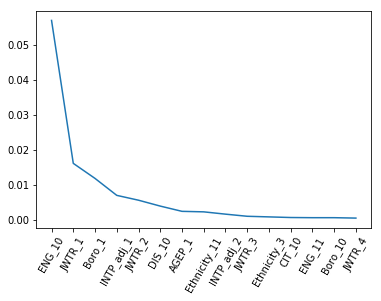

In [49]:
imps = list(zip(X_train.columns, pipeline.named_steps['clf'].feature_importances_))
imps=(sorted(imps, key=lambda tup: tup[1]))
imps.reverse()
#geometric_mean_score(y_test, pipeline.predict(X_test)) # 0.8741667300789631
labels_i = [x[0] for x in imps][:15]
ys_i = [x[1] for x in imps][:15]
plt.plot(labels_i, ys_i)
plt.xticks(rotation=60)

### Feature Engineering - No Financials
This will be as above, but pulling out the financial variables.

In [51]:
X2 = all_2016.copy()

categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro', 'NP', 'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']

# We'll create separate dataframes for personal and poverty-unit variables, then join them together
personal_columns = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro']
pu_columns = ['NP', 'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU', 'NYCgov_Pov_Stat']

# Create a dataframe for the personal columns, including our 3 indicator variables
X2_pers = X2.copy()
X2_pers_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + personal_columns
X2_pers = X2_pers[X2_pers_columns]

# Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
X2_pers = X2_pers.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

# Turn the multi-index columns into a single indexed column: 'AGEP_1', 'AGEP_2', 'AGEP_3', etc.
X2_pers.columns = list(map('_'.join, [(y, str(z)) for y, z in (x for x in X2_pers.columns)]))

# Create a dataframe for the poverty-unit columns, including our 3 indicator variables
X2_pu = X2.copy()
X2_pu_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + pu_columns
X2_pu = X2_pu[X2_pu_columns]

# Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
X2_pu = X2_pu.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

# Groupby and take the max of SPORDER (these are poverty-unit variables; if there is a nonzero value, it's unique)
X2_pu = X2_pu.stack().groupby(['SERIALNO', 'Povunit_ID']).max()

# Add the personal and poverty-unit dataframes
X2 = X2_pers.add(X2_pu, fill_value=0)
X2.tail()

,,AGEP_1,AGEP_10,AGEP_11,AGEP_12,AGEP_13,AGEP_14,AGEP_15,AGEP_16,AGEP_17,AGEP_18,...,WKW_19,WKW_2,WKW_20,WKW_3,WKW_4,WKW_5,WKW_6,WKW_7,WKW_8,WKW_9
SERIALNO,Povunit_ID,,,,,,,,,,,,,,,,,,,,,
1521345,1,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521371,1,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521389,1,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521399,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521415,1,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Pull off 'NYCgov_Pov_Stat' for our target variable
y2 = X2['NYCgov_Pov_Stat'].replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}})
X2 = X2.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, stratify=y2)

# Transforms for pipeline: 
# 1) categorize to prep for one-hot encoding
# 2) one-hot encode, dropping one to avoid colinearity
# 3) deal with imbalanced data with sampling strategies (poverty is ~20% of total)
# 4) scale data
# 5) classifiers
categorizer = Categorizer(columns=dummy_these)
dummy_encoder = DummyEncoder(drop_first=True)
#samplers = [SMOTE(random_state=42), SMOTETomek(random_state=42), TomekLinks(random_state=42)]
scaler = Normalizer()
classifier = RandomForestClassifier(n_estimators=1000, max_features=100)

cachedir = tempfile.mkdtemp()

pipeline = imbPipeline(steps=[('cat', categorizer),
                              ('dummies', dummy_encoder),
                              ('scaler', scaler),
                              ('clf', classifier)], 
                      memory=cachedir)
                    
t0 = time.time()
pipeline.fit(X2_train, y2_train)
time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 1.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 0.64s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can

Took: 977.44s to fit 


In [54]:
#pipeline.named_steps['clf'].feature_importances_
imps = list(zip(pipeline.named_steps['clf'].feature_importances_, X2_train.columns))
sorted(imps, key=lambda tup: tup[0])[-15:]
#geometric_mean_score(y2_test, pipeline.predict(X2_test)) # 0.5891144868773415

[(0.0019536750561223435, 'CIT_16'),
 (0.0019766238091623893, 'CIT_8'),
 (0.002074372847437007, 'CIT_19'),
 (0.002103638190090756, 'CIT_7'),
 (0.0021084495403344244, 'CIT_12'),
 (0.002192773240239379, 'CIT_20'),
 (0.0022114526799705417, 'CIT_5'),
 (0.0022167018769647475, 'CIT_15'),
 (0.0023101070754851017, 'CIT_18'),
 (0.0023378895980513356, 'DIS_7'),
 (0.0023659286886432707, 'CIT_6'),
 (0.0024051439784516827, 'CIT_3'),
 (0.0024677871327048293, 'CIT_17'),
 (0.002469216276971846, 'CIT_14'),
 (0.002591447212012863, 'CIT_4')]

In [62]:
all_2016.INTP_adj.describe()
#len(all_2016[all_2016.INTP_adj > 0])
X.loc[X.INTP_adj > 0, 'INTP_adj'].describe()

AttributeError: 'DataFrame' object has no attribute 'INTP_adj'

In [89]:
trials = all_2016.copy()

categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro', 'NP', 'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']

# We'll create separate dataframes for personal and poverty-unit variables, then join them together
#personal_columns = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'Ethnicity', 'Boro']
personal_nums = ['WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj'] 
#pu_columns = ['NP', 'TEN', 'HHT', 'MRGP_adj', 'RNTP_adj', 'HousingStatus', 'TotalWorkHrs_PU', 'NYCgov_Pov_Stat']

# Create a dataframe for the personal columns, including our 3 indicator variables
#X_pers = X.copy()
#X_pers_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + personal_columns
#X_pers = X_pers[X_pers_columns]

# Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
#X_pers = X_pers.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

# Turn the multi-index columns into a single indexed column: 'AGEP_1', 'AGEP_2', 'AGEP_3', etc.
#X_pers.columns = list(map('_'.join, [(y, str(z)) for y, z in (x for x in X_pers.columns)]))

# Create a dataframe for the poverty-unit columns, including our 3 indicator variables
X_trials = trials.copy()
X_trials_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + personal_nums
X_trials = X_trials[X_trials_columns]

# Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
X_trials = X_trials.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

# Groupby and take the max of SPORDER (these are poverty-unit variables; if there is a nonzero value, it's unique)
X_trials = X_trials.stack().groupby(['SERIALNO', 'Povunit_ID']).sum()

# Add the personal and poverty-unit dataframes
#X = X_pers.add(X_pu, fill_value=0)
#X.tail()
#X_trials[X_trials.OI_adj > 0].OI_adj.describe()
#X_trials.MRGP_adj.describe()
#all_2016[all_2016.Povunit_Rel == 1].RNTP_adj.describe()
#all_2016.loc[(all_2016.Povunit_Rel == 1) & (all_2016.RNTP_adj > 0)].RNTP_adj.describe()
all_2016['RNTP+MRGP'] = all_2016.RNTP_adj + all_2016.MRGP_adj
all_2016.loc[(all_2016.Povunit_Rel == 1) & (all_2016['RNTP+MRGP'] > 0)]['RNTP+MRGP'].describe()

/home/chachi/miniconda3/envs/pandas-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


count    24259.000000
mean      1623.764093
std        994.621840
min          4.030352
25%        967.284480
50%       1410.623200
75%       2115.934800
max       6448.563200
Name: RNTP+MRGP, dtype: float64

In [6]:
fX = all_2016.copy()
print(fX[['SERIALNO', 'SPORDER', 'Povunit_ID', 'ENG', 'WKW', 'TotalWorkHrs_PU']].head(10))
fix_orders = {'ENG': {0:0, 4:1, 3:2, 2:3, 1:4, 5:5}, 'WKW': {0:0, 6:1, 5:2, 4:3, 3:4, 2:5, 1:6}, 
              'TotalWorkHrs_PU': {5:0, 4:1, 3:2, 2:3, 1:4}}
#fX[['SERIALNO', 'SPORDER', 'Povunit_ID', 'ENG', 'WKW', 'TotalWorkHrs_PU']].map(fix_orders).head(10)
fX['ENG'] = fX['ENG'].map(fix_orders['ENG'])
fX['WKW'] = fX['WKW'].map(fix_orders['WKW'])
fX['TotalWorkHrs_PU'] = fX['TotalWorkHrs_PU'].map(fix_orders['TotalWorkHrs_PU'])
print(fX[['SERIALNO', 'SPORDER', 'Povunit_ID', 'ENG', 'WKW', 'TotalWorkHrs_PU']].head(10))

#Number of adults, number of kids, number of retirement-age adults, number of working-age adults, any kids, 
#any retirement-age adults
fX['n_adults'] = fX

        SERIALNO  SPORDER  Povunit_ID  ENG  WKW  TotalWorkHrs_PU
710612        39        1           1  1.0  0.0                5
710613        55        1           1  5.0  1.0                1
710614        55        2           1  5.0  1.0                1
710615        55        3           1  5.0  2.0                1
710616        55        4           1  5.0  5.0                1
710617        55        5           1  5.0  4.0                1
710618        69        1           1  5.0  1.0                3
710619       210        1           1  5.0  1.0                2
710620       261        1           1  5.0  1.0                2
710621       261        2           1  5.0  0.0                2
        SERIALNO  SPORDER  Povunit_ID  ENG  WKW  TotalWorkHrs_PU
710612        39        1           1    4    0                0
710613        55        1           1    5    6                4
710614        55        2           1    5    6                4
710615        55        3